## Traininig of the High Level Feature classifier with TensorFlow/Keras

**4.0 Tensorflow/Keras, HLF classifier** This notebooks trains a dense neural network for the particle classifier using High Level Features. It uses TensorFlow/Keras on a single node. Pandas is used to read the data and pass it to TensorFlow.

The High-Level Features classifier is built with labeled data
 - input: 14 features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)
![Physics use case for the particle classifier](../Docs/Physics_use_case.png)

To run this notebook we used the following configuration:
* *Software stack*: 
* Pandas 1.5.3
* TensorFlow 2.11.0 
* Platform: CentOS 7, Python 3.9

## Load train and test datasets via Pandas

In [1]:
# Download the datasets from 
# ** https://github.com/cerndb/SparkDLTrigger/tree/master/Data **
#
# For CERN users, data is already available on EOS
PATH = "/eos/project/s/sparkdltrigger/public/"

# PATH = "../Data/sparkdltrigger.web.cern.ch/sparkdltrigger/"

import pandas as pd

testPDF = pd.read_parquet(path= PATH + 'testUndersampled_HLF_features.parquet', 
                          columns=['HLF_input', 'encoded_label'])

trainPDF = pd.read_parquet(path= PATH + 'trainUndersampled_HLF_features.parquet', 
                           columns=['HLF_input', 'encoded_label'])

In [2]:
# Check the number of events in the train and test datasets

num_test = testPDF.count()
num_train = trainPDF.count()

print('There are {} events in the test dataset'.format(num_test))
print('There are {} events in the train dataset'.format(num_train))

There are HLF_input        856090
encoded_label    856090
dtype: int64 events in the test dataset
There are HLF_input        3426083
encoded_label    3426083
dtype: int64 events in the train dataset


In [3]:
# Show the schema and a data sample of the test dataset
testPDF


,HLF_input,encoded_label
0,"[0.015150733133517018, 0.003511028294205839, 0...","[1.0, 0.0, 0.0]"
1,"[0.0, 0.003881822832783805, 0.7166341448458555...","[1.0, 0.0, 0.0]"
2,"[0.009639073600865505, 0.0010022659022912096, ...","[1.0, 0.0, 0.0]"
3,"[0.016354407625436572, 0.002108937905084598, 0...","[1.0, 0.0, 0.0]"
4,"[0.01925979125354152, 0.004603697276827594, 0....","[1.0, 0.0, 0.0]"
...,...,...
856085,"[0.020383967386165446, 0.0022348975484913444, ...","[0.0, 1.0, 0.0]"
856086,"[0.02475209699743233, 0.00867502196073073, 0.3...","[0.0, 1.0, 0.0]"
856087,"[0.03498179428310887, 0.02506331737284528, 0.9...","[0.0, 1.0, 0.0]"
856088,"[0.03735147362869153, 0.003645269183639405, 0....","[0.0, 1.0, 0.0]"


## Convert training and test datasets from Spark DataFrames to Numpy arrays

Now we will collect and convert the Spark DataFrame into numpy arrays in order to be able to feed them to TensorFlow/Keras.
We use the toPandas optimization in Spark to move data faster bewteen JVM and Python.


In [4]:
import numpy as np

X = np.stack(trainPDF["HLF_input"])
y = np.stack(trainPDF["encoded_label"])

X_test = np.stack(testPDF["HLF_input"])
y_test = np.stack(testPDF["encoded_label"])

## Create the Keras model

In [6]:
import tensorflow as tf
tf.__version__

'2.11.0'

In [7]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

def create_model(nh_1, nh_2, nh_3):
    ## Create model
    model = Sequential()
    model.add(Dense(nh_1, input_shape=(14,), activation='relu'))
    model.add(Dense(nh_2, activation='relu'))
    model.add(Dense(nh_3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    
    ## Compile model
    optimizer = 'Adam'
    loss = 'categorical_crossentropy'
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    
    return model

keras_model = create_model(50,20,10)

2023-03-10 19:32:38.647685: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:32:39.174869: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3312 MB memory:  -> device: 0, name: Quadro K2200, pci bus id: 0000:02:00.0, compute capability: 5.0


## Train the model

In [9]:
batch_size = 128
n_epochs = 5

%time history = keras_model.fit(X, y, batch_size=batch_size, epochs=n_epochs, \
                                validation_data=(X_test, y_test))


Epoch 1/5


2023-03-10 19:32:42.358764: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2214015090 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-10 19:32:42.358802: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Quadro K2200, Compute Capability 5.0
2023-03-10 19:32:42.364950: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-10 19:32:42.803417: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


26767/26767 [==============================] - 62s 2ms/step - loss: 0.2816 - accuracy: 0.8966 - val_loss: 0.2469 - val_accuracy: 0.9097
Epoch 2/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2429 - accuracy: 0.9104 - val_loss: 0.2406 - val_accuracy: 0.9109
Epoch 3/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2371 - accuracy: 0.9124 - val_loss: 0.2365 - val_accuracy: 0.9122
Epoch 4/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2334 - accuracy: 0.9137 - val_loss: 0.2311 - val_accuracy: 0.9147
Epoch 5/5
26767/26767 [==============================] - 58s 2ms/step - loss: 0.2300 - accuracy: 0.9151 - val_loss: 0.2280 - val_accuracy: 0.9157
CPU times: user 6min 55s, sys: 37.7 s, total: 7min 33s
Wall time: 4min 55s


## Performance metrics

<IPython.core.display.Javascript object>


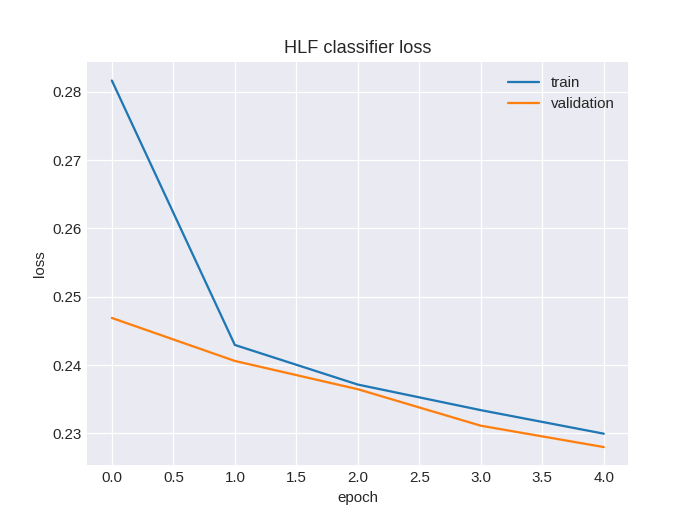

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


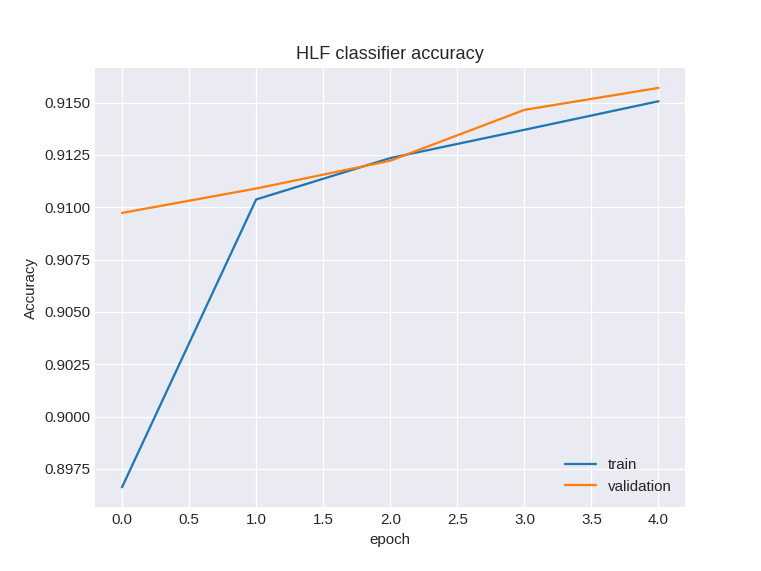

In [11]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [12]:
y_pred=history.model.predict(X_test)
y_true=y_test

26753/26753 [==============================] - 24s 882us/step


In [13]:
from sklearn.metrics import accuracy_score

print('Accuracy of the HLF classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the HLF classifier: 0.9157


/tmp/luca/ipykernel_29722/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


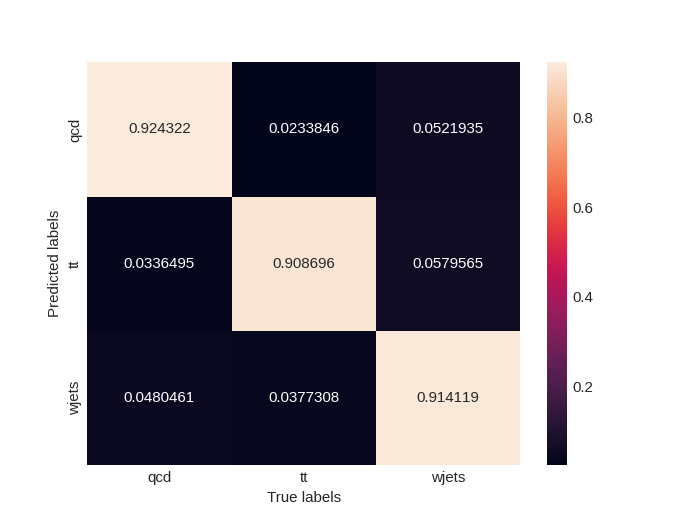

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [15]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [16]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9873626374256744, 1: 0.9853905073079492, 2: 0.9813265004442492}

<IPython.core.display.Javascript object>


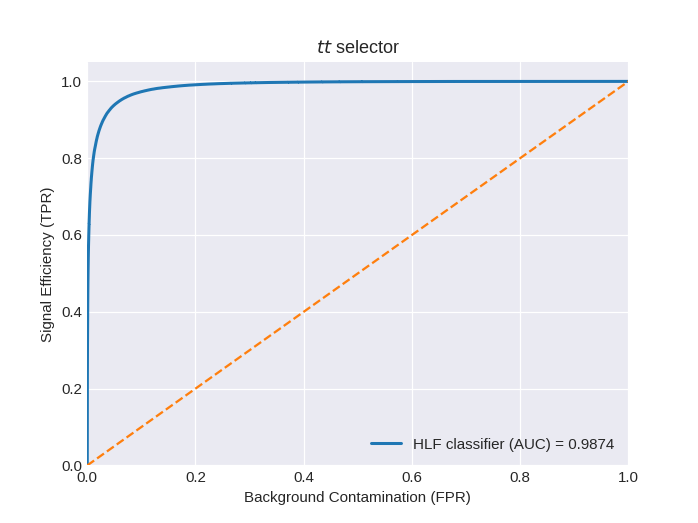

In [17]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, \
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()